In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Class to represent a camera
# It holds the calibration as well as the distortion
class Camera:
    
    def __init__(self):
        # The camera matrix and distortion coeffs
        # are filled after calibration
        self.is_calibrated       = False
        self.camera_matrix       = None
        self.distortion_coeffs   = None
    
    def calibrate(self, calibration_files, chessboard_ncorners=(9,6)):
        '''
            calibrate the camera based on files provided
            We use only chessboard image to calibrate
            All images must have the same shape
        '''

        # Store informations about the differents points required
        # to interpolate the camera distortion
        object_points = [] # Store 3d points from real world
        image_points  = [] # Store 2d points from the image

        # The chessboard number of corners
        nx, ny = chessboard_ncorners

        # Generate the object_points for this chessboard
        # Init an array with the number of points and 3 coordinates
        chessboard_object_points = np.zeros((nx*ny, 3), np.float32)
        # Now create a grid of nx by ny letting the z coordinate to zero
        chessboard_object_points[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

        # loop on the calibration images
        for cal_image_file in calibration_files:

            # Read the image
            img = cv2.imread(cal_image_file)
            # Convert to gray
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Now find the chessboard corners
            is_corner_found, corners = cv2.findChessboardCorners(gray, (nx,ny))

            # If we found the corners
            if is_corner_found:
                # Add our points to the lists
                image_points.append(corners)
                object_points.append(chessboard_object_points)

        # Calibrate our camera with all those points
        retval, self.camera_matrix, self.distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img.shape[0:2], None, None)
        self.is_calibrated = True
        
        
    def undistort(self, img):
        '''
            Undistort image based on the calibration done
        '''
        assert self.is_calibrated, 'Camera has not been calibrated, do it first.'
        
        return cv2.undistort(img, self.camera_matrix, self.distortion_coeffs)
        

In [3]:
# Class to handle perspective transformation
class Perspective:
    def __init__(self, src_points, dst_points):
        '''
            Init the object based on the points
            provided, we need 4 points to be able to
            compute the perspective transformation
        '''
        assert len(src_points) == 4, 'Source points size != 4'
        assert len(dst_points) == 4, 'Destination points size != 4'
        
        # Compute matrix perspective
        self.matrix         = cv2.getPerspectiveTransform(src_points, dst_points)
        self.matrix_inverse = cv2.getPerspectiveTransform(dst_points, src_points)
        
    def transform(self, img, size=None):
        '''
            Transform the image using the perspective
            from source to destination
            size : The size (width, height) of the image  wanted
                   
        '''
        if size == None:
            size = (img.shape[1], img.shape[0])
            
        return cv2.warpPerspective(img, self.matrix, size, flags=cv2.INTER_LINEAR)

    def transform_inv(self, img, size=None):
        '''
            Transform the image using the perspective
            from destination to source
            size : The size (width, height) of the image  wanted
                   
        '''
        if size == None:
            size = (img.shape[1], img.shape[0])
            
        return cv2.warpPerspective(img, self.matrix_inverse, size, flags=cv2.INTER_LINEAR)    

In [4]:
# Create a camera and calibrate it
# using all chessboard images available
camera = Camera()
camera.calibrate(glob.glob('./camera_cal/calibration*.jpg'))


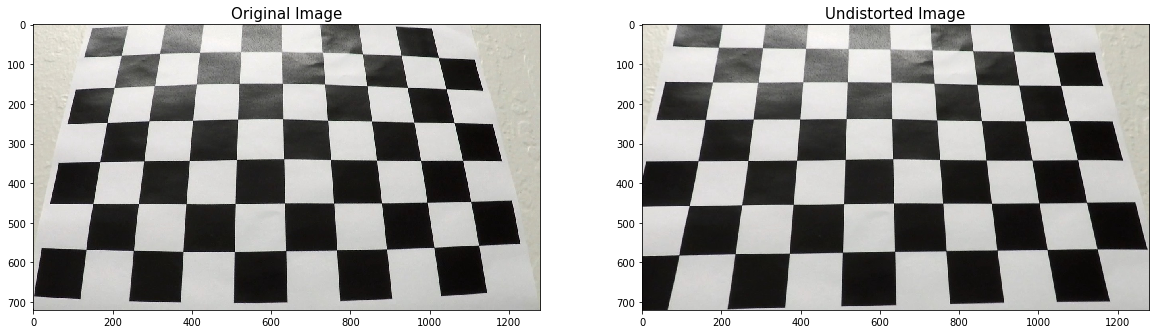

In [5]:
# Example of the distortion of the camera and the undistort image associated
img_ori = cv2.cvtColor(cv2.imread('./camera_cal/calibration3.jpg'), cv2.COLOR_BGR2RGB)
img     = camera.undistort(img_ori)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_ori)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=15)


plt.show()

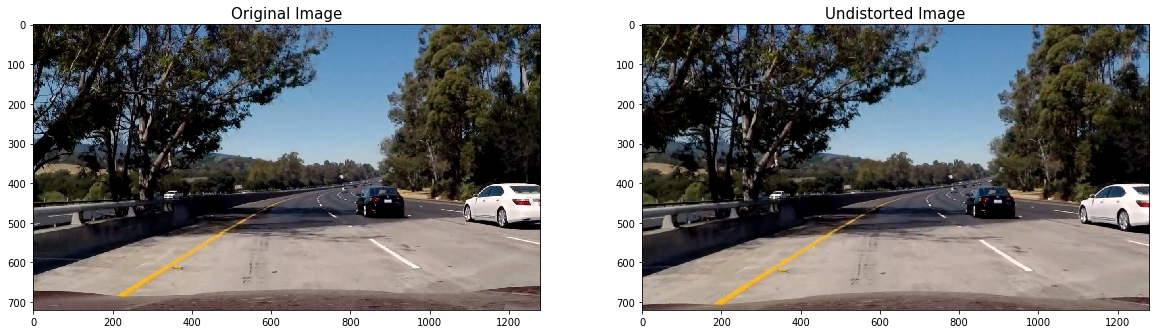

In [6]:
# Undistort example
img_ori = cv2.cvtColor(cv2.imread('./test_images/test5.jpg'), cv2.COLOR_BGR2RGB)
img     = camera.undistort(img_ori)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_ori)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=15)


plt.show()


In [7]:
# Used image application to select the 4 points from the perspective images
# The points have been selected manually in the image above
src_perspective_points = np.float32( [ [280.0,675.0], [573.0,465.0], [712.0,465.0], [1042.0,675.0] ])

# Define for the bird eyes view so the line are parallel
dst_perspective_points = np.float32( [ [355.0,719.0], [355.0,0.0], [955.0,0.0], [955.0,719.0] ])

# Generate a perspective
birdeyes_perspective = Perspective(src_perspective_points, dst_perspective_points)


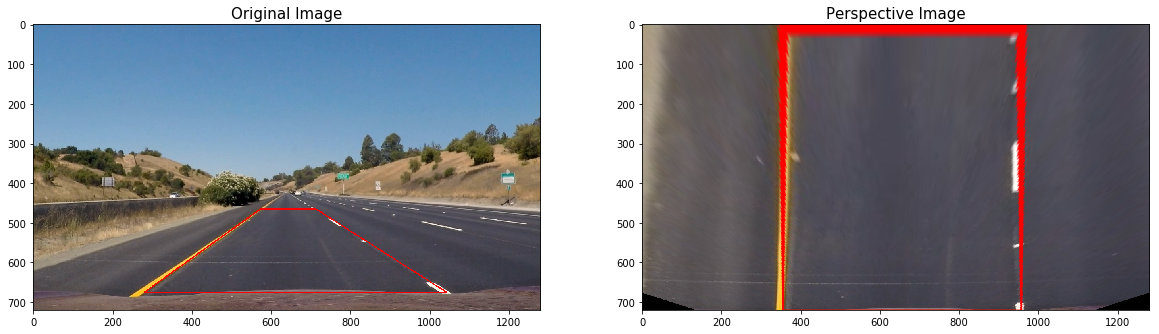

In [8]:
# Example of an image projected on the birdeyes perspective with the polygon used to compute the perspective
img = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
cv2.polylines(img, np.int32([src_perspective_points]), True, (255,0,0), 2)

birdeyes_img = birdeyes_perspective.transform(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(birdeyes_img)
ax2.set_title('Perspective Image', fontsize=15)


plt.show()

In [9]:
def channel_threshold(img, thresh):
    '''
        Return a binary image based on 
        the threshold provided
        img must be a one channel image
    '''

    # Threshold channel
    img_binary = np.zeros_like(img)
    img_binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    
    return img_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
        Return binay img after computing the gradient
        and using the threshold
        img must be a one channel image
    '''
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(sobel * 255 / np.max(sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    i_binary = np.zeros_like(scaled_sobel)
    i_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return i_binary

In [10]:
def equalize_image(img):
    '''
        Equalize the image by increasing the contrast in the potential
        Lane region.
        Image in hls format
    '''
    # Work on a copy of the image
    img_copy = img[:,:,:]

    # Get the image size
    height, width = img.shape[0:2]
    
    # Select the left region
    # Assumed zone y>444
    # yy > -x + 919 slope -1 passing by 200,719
    # yy < -x +1219 slope -1 passing by 500,719
    XX, YY = np.meshgrid(np.arange(0, width), np.arange(0, height))
    left_region = (YY > 444) & \
                  (YY > (-XX + 919)) & \
                  (YY < (-XX + 1219))
                         
    # Select the right region
    # Assumed zone y>444
    # yy < x - 181 slope 1 passing by 900,719
    # yy > x - 481 slope 1 passing by 1200,719
    right_region = (YY > 444) & \
                   (YY > (XX - 481)) & \
                   (YY < (XX - 181))

    # Select the luminosity pixels from this region
    img_selection = img_copy[left_region | right_region,1]
    
    # Compute the mean of those region
    # Keep it around 80
    mean   = np.mean(img_selection)
    if mean > 100 or mean < 60:
        temp_copy = np.copy(img_copy[:,:,1]).astype(np.float32)
        temp_copy = temp_copy + 80  - int(mean)
        selection = (temp_copy < 0 )
        temp_copy[selection] = 0
        selection = (temp_copy > 255 )
        temp_copy[selection] = 255
        img_copy[:,:,1] = np.int_(temp_copy)

   
    return img_copy                        

In [11]:
def binay_image_extraction(img):
    '''
        Apply different threshold to extract
        the lane feature of the image
        We are using color threshold and gradient threshold
    '''
    # Convert image to HLS, as we will
    # use all the channels to try to discover the lane
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Equalize the image so our threshold remains the same
    # for any exposition
    hls = equalize_image(hls)
    
    # Apply a channel threshold on all three channels
    h_binary = channel_threshold(hls[:,:,0], thresh=(18, 24))
    l_binary = channel_threshold(hls[:,:,1], thresh=(130, 255)) #130 255 / 118 255 / 140 255
    s_binary = channel_threshold(hls[:,:,2], thresh=(80, 255)) #28 230 / 70 230

    # Apply a gradient threshold on the gray channel
    gradx = abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=5, thresh=(15, 255))

    # Now combined all the binary images
    combined = np.zeros_like(h_binary)
    combined[ ((h_binary == 1) & (s_binary == 1)) | ((gradx == 1) & (l_binary == 1)) ] = 1
    
    # Remove salt&pepper like noise
    combined = cv2.medianBlur(combined, ksize=3)
    
    return combined

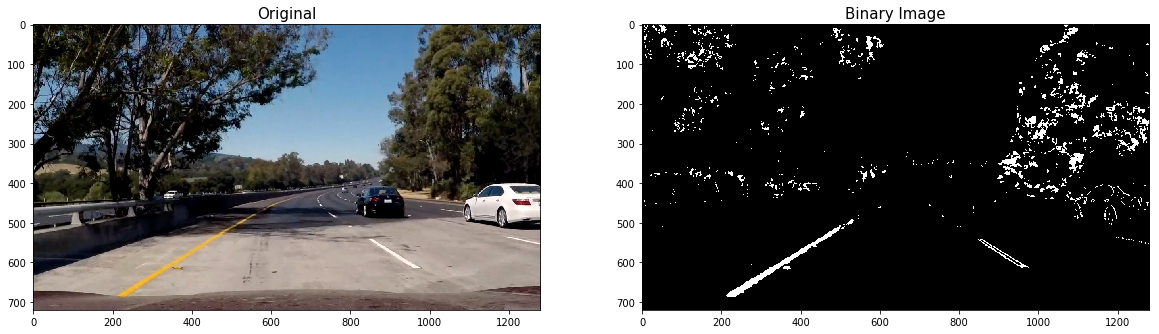

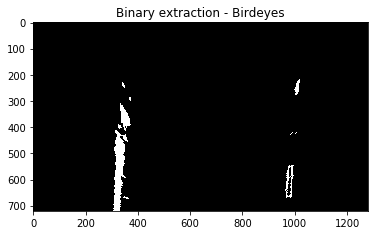

In [12]:
# Example of the binary extraction

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_ori)
ax1.set_title('Original', fontsize=15)

img_binary = binay_image_extraction(img_ori)
ax2.imshow(img_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=15)
plt.show()

img_binary_birdeyes = birdeyes_perspective.transform(img_binary)
plt.imshow(img_binary_birdeyes, cmap='gray')
plt.title('Binary extraction - Birdeyes')
plt.show()



In [13]:
# Define some constants
XMETER_PER_PIXEL = 3.7/592 # meters per pixel in x dimension in birdeyes view
YMETER_PER_PIXEL = 20/720  # meters per pixel in Y dimension in birdeyes view ( assumed 20 meters base on lane length)

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit  = None
        self.iteration = 0
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Polynom
        self.p = None
        
    # Just convenient fonction to get
    # a value from the current fit
    def poly1d(self, value):
        return self.p(value)
        
    def get_curvature(self, yval):
        '''
            Get the curvature of the line based
            on the coordinate
        '''
        # Fit a polynomials to x,y in world space
        poly_fit  = np.polyfit(self.ally* YMETER_PER_PIXEL,  self.allx*XMETER_PER_PIXEL, 2)

        curv = ( ( 1 + ( 2*poly_fit[0]*yval*YMETER_PER_PIXEL + poly_fit[1]) ** 2) ** 1.5) \
             / np.absolute( 2*poly_fit[0])

        return curv
    
    def new_dataset(self, allx, ally):
        '''
            Add the new points to the line
            Compute the current fit and best fit
        '''
        # Extract all pixels selected to be in our lines
        # And update our lines objects
        self.allx  = allx
        self.ally  = ally

        # Interpolate a line
        if len(allx) != 0 and len(ally) != 0:
            self.current_fit  = np.polyfit(ally , allx , 2)
            # Increase the iteration
            self.iteration += 1
            # Limit it to 10
            self.iteration = min(5, self.iteration)
            # Compute the new average
            if self.iteration > 1:
                self.best_fit = (self.best_fit * (self.iteration - 1 ) + self.current_fit ) / self.iteration
            else:
                self.best_fit = self.current_fit

            # Update the polynom    
            self.p = np.poly1d(self.best_fit)
        
        

In [14]:
# Define some constants
N_WINDOWS     = 36 # number of windows for the research
WINDOW_XMARGIN = 75 # Margin so our window has a width of 2*WINDOW_XMARGIN

def line_fit_blindsearch(img, left_line, right_line):
    '''
        Detect the lanes based on the image in birdeyes view
        using a blind search with windows
        The image has to be a binary image
        left_line, right_line are updated accordingly
    '''
    
    # Determine our base x an y, to know where to start our search
    
    # Get the repartition of the pixels by x 
    # using the bottom 3/4 of the image
    histogram = np.sum(img[(img.shape[0]*3)//4:,:], axis=0)
    
    # Based on the midpoint, search on left and right
    # where there is the most data
    midpoint_x = histogram.shape[0]//2

    # Line x coordinates
    left_x_base  = np.argmax(histogram[:midpoint_x])
    right_x_base = np.argmax(histogram[midpoint_x:]) + midpoint_x
    
    # If the line are not at the correct distance
    # Not in the range [2.5, 4.5] meters
    # use another approach to determine the lines
    # position, we select the first x over 20 votes
    x_distance_m = (right_x_base - left_x_base) * XMETER_PER_PIXEL
    if x_distance_m < 2.5  or x_distance_m > 4.5:
        # Select all coordinates with more than 20 pixels
        h_binary = np.zeros_like(histogram)
        h_binary[(histogram > 20)] = 1

        # Now get the leftx and right position
        nonzero = h_binary[:midpoint_x].nonzero()
        if len(nonzero) > 1:
            left_x_base  = nonzero[-1][-1]
        else:
            left_x_base = 0
            
        nonzero = h_binary[midpoint_x:].nonzero()
        if len(nonzero) > 1:                
            right_x_base = nonzero[0][0] + midpoint_x
        else:
            right_x_base = img.shape[1]
        
        # If the distance is still not appropriate we can't do anything
        x_distance_m = (right_x_base - left_x_base) * XMETER_PER_PIXEL
        if x_distance_m < 2.5  or x_distance_m > 4.5:
            return

    # Get all coordinates of non zero pixels
    nonzeros  = img.nonzero()
    nonzero_y = np.array(nonzeros[0])
    nonzero_x = np.array(nonzeros[1])


    height, width = img.shape

    window_height = height / N_WINDOWS

    # Start the search at our base
    left_x_current  = left_x_base
    right_x_current = right_x_base

    # Arrays to keep all pixels found
    left_inds  = []
    right_inds = []

    for window_n in range(N_WINDOWS):
        # Define the boundaries of the window
        win_y_bottom = height -  window_n      * window_height
        win_y_top    = height - (window_n + 1) * window_height

        left_win_x_left  = left_x_current - WINDOW_XMARGIN
        left_win_x_right = left_x_current + WINDOW_XMARGIN

        right_win_x_left  = right_x_current - WINDOW_XMARGIN
        right_win_x_right = right_x_current + WINDOW_XMARGIN

        # Select the pixels in the window, keeping only the one that matches
        selected_left_inds = (  (nonzero_y >= win_y_top)       \
                              & (nonzero_y <  win_y_bottom)    \
                              & (nonzero_x >= left_win_x_left) \
                              & (nonzero_x <  left_win_x_right)
                             ).nonzero()[0]

        selected_right_inds = (  (nonzero_y >= win_y_top)        \
                               & (nonzero_y <  win_y_bottom)     \
                               & (nonzero_x >= right_win_x_left) \
                               & (nonzero_x <  right_win_x_right)
                              ).nonzero()[0]

        # Add the new indices to the list
        left_inds.extend(selected_left_inds)
        right_inds.extend(selected_right_inds)

        # If we have enough point, adjust the next window
        if len(selected_left_inds) > 30:
            left_x_current = np.int(np.mean(nonzero_x[selected_left_inds]))

        if len(selected_right_inds) > 30:
            right_x_current = np.int(np.mean(nonzero_x[selected_right_inds]))


    # Extract all pixels selected to be in our lines
    # And update our lines objects
    left_line.new_dataset(nonzero_x[left_inds], nonzero_y[left_inds])
    right_line.new_dataset(nonzero_x[right_inds], nonzero_y[right_inds])        
    

In [15]:
def line_fit_targetedsearch(img, left_line, right_line):
    '''
        Use the current fit information to do the pixel search
    '''
    # Get all coordinates of non zero pixels
    nonzeros  = img.nonzero()
    nonzero_y = np.array(nonzeros[0])
    nonzero_x = np.array(nonzeros[1])

    # Arrays to keep all pixels found
    left_inds  = (  (nonzero_x > (left_line.poly1d(nonzero_y) - WINDOW_XMARGIN)) 
                  & (nonzero_x < (left_line.poly1d(nonzero_y) + WINDOW_XMARGIN))
                 ) 
    right_inds = (  (nonzero_x > (right_line.poly1d(nonzero_y) - WINDOW_XMARGIN)) 
                  & (nonzero_x < (right_line.poly1d(nonzero_y) + WINDOW_XMARGIN))
                 ) 

    # Extract all pixels selected to be in our lines
    # And update our lines objects
    left_line.new_dataset(nonzero_x[left_inds], nonzero_y[left_inds])
    right_line.new_dataset(nonzero_x[right_inds], nonzero_y[right_inds])
    

In [16]:
def get_lane_deviation(img_size, left_line, right_line):
    x_left  = left_line.poly1d(img_size[0])
    x_right = right_line.poly1d(img_size[0])
    deviation  = ((x_left + x_right - img_size[1]) / 2 )* XMETER_PER_PIXEL
    
    return deviation


In [17]:
def get_lane_curvature(img_size, left_line, right_line):
    # Calculate the radius of curvature for both lines
    left_curv  = left_line.get_curvature(img_size[0])
    right_curv = right_line.get_curvature(img_size[0])
    
    # Then average it
    return (left_curv + right_curv) / 2

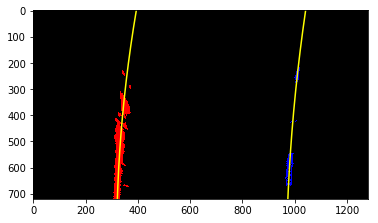

In [18]:
# Example of the fitting process intermediate result

# Create line objects
left_line  = Line()
right_line = Line()

img_binary = binay_image_extraction(img_ori)
img_binary_birdeyes = birdeyes_perspective.transform(img_binary)

# Make a blind research
line_fit_blindsearch(img_binary_birdeyes, left_line, right_line)


# Genearate an rgb image to color the pixels selected
out_img = np.dstack((img_binary_birdeyes, img_binary_birdeyes, img_binary_birdeyes)).astype(np.uint8)*255

# Color left/right line
out_img[left_line.ally,  left_line.allx]  = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

# Draw the lines found
fity = np.linspace(0, img_binary_birdeyes.shape[0]-1, img_binary_birdeyes.shape[0] )

fit_leftx  = left_line.poly1d(fity) 
fit_rightx = right_line.poly1d(fity)

plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.show()

In [19]:
def add_lane_detection_overlay(img, left_line, right_line):
    '''
        Will add a green overlay on the detected lane
        in the image provided
    '''
    # Generate the polygon points
    fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    fit_leftx  = left_line.poly1d(fity)
    fit_rightx = right_line.poly1d(fity)

    pts  = list(zip(fit_leftx, fity))
    right_pts = list(zip(fit_rightx,fity))
    right_pts = right_pts[::-1]

    pts.extend(right_pts)

    # Prepare our overlay
    wrap_back = np.zeros_like(img).astype(np.uint8)

    # Fill the polygon
    cv2.fillPoly(wrap_back, np.int_([pts]), (0,255,0))

    overlay = birdeyes_perspective.transform_inv(wrap_back)

    return cv2.addWeighted(img, 1, overlay, 0.3, 0)
    

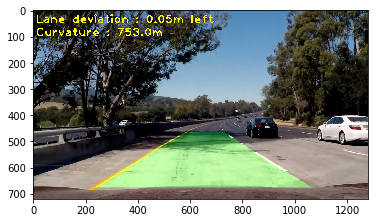

In [20]:
# Create line objects
left_line  = Line()
right_line = Line()

img_binary = binay_image_extraction(img_ori)
img_binary_birdeyes = birdeyes_perspective.transform(img_binary)

# Make a blind research
line_fit_blindsearch(img_binary_birdeyes, left_line, right_line)

result = add_lane_detection_overlay(img_ori, left_line, right_line)

ld = get_lane_deviation(img.shape[0:2], left_line, right_line)
if ld > 0.0:
    position = 'left'
else:
    position = 'right'
    
cv2.putText(result,'Lane deviation : {:.2f}m {}'.format(abs(ld), position), (10,50), cv2. FONT_HERSHEY_PLAIN, 3, (255,255,0), 4)

lc = get_lane_curvature(img.shape[0:2], left_line, right_line)
cv2.putText(result,'Curvature : {:.1f}m'.format(lc), (10,100), cv2. FONT_HERSHEY_PLAIN, 3, (255,255,0), 4)

plt.imshow(result)
plt.show()



In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
left_line  = Line()
right_line = Line()

img_n = 0


def process_image(img):
    #global img_n
    #img_n += 1
    #cv2.imwrite( './videos_images/v{:03d}.png'.format(img_n), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    # Undistort
    img = camera.undistort(img)
    
    # Extract lines
    combined = binay_image_extraction(img)
    combined = birdeyes_perspective.transform(combined)

   
    # If we have already a fit, use it
    if left_line.best_fit != None and right_line.best_fit != None:
        line_fit_targetedsearch(combined, left_line, right_line)
    else:
        line_fit_blindsearch(combined, left_line, right_line)

    

    # Put our prediction back to the image
    result = add_lane_detection_overlay(img, left_line, right_line)
    

    # Add deviation from center
    ld = get_lane_deviation(img.shape[0:2], left_line, right_line)
    if ld > 0.0:
        position = 'left'
    else:
        position = 'right'

    cv2.putText(result,'Lane deviation : {:.2f}m {}'.format(abs(ld), position), (10,50), cv2. FONT_HERSHEY_PLAIN, 3, (255,255,0), 4)

    # Add curvature
    lc = get_lane_curvature(img.shape[0:2], left_line, right_line)
    cv2.putText(result,'Curvature : {:.1f}m'.format(lc), (10,100), cv2. FONT_HERSHEY_PLAIN, 3, (255,255,0), 4)


    return result

In [23]:
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  6.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 28s, sys: 14.7 s, total: 3min 43s
Wall time: 3min 7s
